In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import zscore

In [2]:
# load data
cell_num = 884
m = 3
trial_num = 77
positions = np.load('./Behaviour.npy', allow_pickle=True)
speed = np.load('./Speed.npy', allow_pickle=True)
dff_traces = np.load('./DFF_traces.npy', allow_pickle=True)
contexts = np.load('./Map_index.npy', allow_pickle=True)
pointer = np.load('./sync.npy', allow_pickle=True)

In [3]:
cell_num = 884
m = 3
trial_num = 77
map1_dff = np.load('./mapdata/Map1.npy', allow_pickle=True)
map1_pl = np.load('./mapdata/m1_pc.npy', allow_pickle=True)
map2_dff = np.load('./mapdata/Map2.npy', allow_pickle=True)
map2_pl = np.load('./mapdata/m2_pc.npy', allow_pickle=True)
map3_dff = np.load('./mapdata/Map3.npy', allow_pickle=True)
map3_pl = np.load('./mapdata/m3_pc.npy', allow_pickle=True)
map4_dff = np.load('./mapdata/Map4.npy', allow_pickle=True)
map4_pl = np.load('./mapdata/m4_pc.npy', allow_pickle=True)

In [ ]:
# reduce calcium white noise
# a wavelet-based denoising algorithm
# Savitsky-Golay filtering


### correlation during pre/post 4ef

In [4]:
# get rest periods v<2cm/s from pre and post periods and smooth with gaussian kernel
def get_rest(velocity, activity):  # velocity: [v over time] activity:[cell_id, activity]
    cell_num = activity.shape[0]
    indexs = np.where(velocity > 2)[0]
    res_activity = activity[:, indexs[:]]
    return res_activity

def smooth(dffs, s_bins=15): # dffs: [cell_id, activity across positions]
    cell_num = dffs.shape[0]
    s_gaussian_kernel = np.exp(-(np.arange(s_bins)-(s_bins-1)/2)**2/2)
    s_gaussian_kernel = s_gaussian_kernel / np.sum(s_gaussian_kernel*np.arange(s_bins))
    smooth_dffs = np.zeros(dffs.shape)
    for i in range(s_bins-1):
        smooth_dffs[:, i] = (dffs[:, :i+1] @ s_gaussian_kernel[s_bins-i-1:].reshape(1+i, 1)).reshape(cell_num)
    for i in range(s_bins-1, dffs.shape[1]):
        smooth_dffs[:, i] = (dffs[:, i-s_bins+1:i+1] @ s_gaussian_kernel.reshape(s_bins, 1)).reshape(cell_num)
    return smooth_dffs

In [ ]:
# Savitzky–Golay filter
# scipy.signal.savgol_filter

In [ ]:
pre_rest = get_rest(speed[0], dff_traces[:, pointer[0]:pointer[1]])
pre_rest = smooth(pre_rest)

In [5]:
def plot_corr(pre_dffs, pos_dffs, pl_peak): # dffs: [cell_id, activity]  pl_peak:[place field center(cm)]  one-to-one
    pl_num = len(pl_peak)
    pre_corr = np.corrcoef(pre_dffs)
    pos_corr = np.corrcoef(pos_dffs)
    pre_line = np.zeros(int(pl_num*(pl_num-1)/2))
    pos_line = np.zeros(pre_line.shape[0])
    pl_dis = np.zeros(pre_line.shape[0])
    for i in range(pl_num):
        for j in range(i):
            pl_dis[int((i-1)*i/2)+j] = abs(pl_peak[i]-pl_peak[j]) / 1000
            pre_line[int((i-1)*i/2)+j] = pre_corr[i, j]
            pos_line[int((i-1)*i/2)+j] = pos_corr[i, j]
    # put in 2cm position window 0.02m
    win = 0.02
    max_dis = np.max(pl_dis)
    min_dis = np.min(pl_dis)
    win_num = int((max_dis-min_dis)/win)+1
    pre_mean = np.zeros(win_num)
    pos_mean = np.zeros(win_num)
    pre_all = [[] for i in range(win_num)]
    pos_all = [[] for i in range(win_num)]
    nums = np.zeros(win_num)
    for k in range(len(pl_dis)):
        pre_mean[int(pl_dis[k]/win)] += pre_line[k]
        pos_mean[int(pl_dis[k]/win)] += pos_line[k]
        pre_all[int(pl_dis[k]/win)].append(pre_line[k])
        pos_all[int(pl_dis[k]/win)].append(pos_line[k])
        nums[int(pl_dis[k]/win)] += 1
    pre_mean /= nums
    pos_mean /= nums
    # add var bar
    pre_var = np.zeros(win_num)
    pos_var = np.zeros(win_num)
    for i in range(win_num):
        pre_var[i] = np.var(np.array(pre_all[i]))
        pos_var[i] = np.var(np.array(pos_all[i]))
    plt.plot(np.linspace(min_dis, min_dis+win*win_num, win_num), pre_mean, label='Pre')
    plt.fill_between(x=np.linspace(min_dis, min_dis+win*win_num, win_num), y1=pre_mean-np.sqrt(pre_var), y2=pre_mean+np.sqrt(pre_var), alpha=0.1)
    plt.plot(np.linspace(min_dis, min_dis+win*win_num, win_num), pos_mean, label='Pos')
    plt.fill_between(x=np.linspace(min_dis, min_dis+win*win_num, win_num), y1=pos_mean-np.sqrt(pos_var), y2=pos_mean+np.sqrt(pos_var), alpha=0.1)
    plt.legend()
    plt.xlabel('Run PF \n peak distance(m)')
    plt.ylabel('Offline Pairwise \n correlation coefficient')
    plt.show()
    

In [6]:
# get pre and pos dffs of place cells and their peaks
def get_peak(pl_id, dff_pos, dffs, pos_bin, pres, poss):  # pl_id:[id of place cells]  dff_pos:[trials, cell_id, activity across positions]
    # pres:[begin of pre, end of pre] poss:[begin of pos, end of pos]
    pl_peak = np.zeros(len(pl_id))
    pre_dffs = np.zeros((len(pl_id), pres[1]-pres[0]))
    pos_dffs = np.zeros((len(pl_id), poss[1]-poss[0]))
    dff_aver = np.mean(dff_pos, axis=0)  # average over trials
    for i in range(len(pl_id)):
        pre_dffs[i, :] = dffs[pl_id[i], pres[0]:pres[1]]
        pos_dffs[i, :] = dffs[pl_id[i], poss[0]:poss[1]]
        pl_peak[i] = np.argmax(dff_aver[pl_id[i]])*pos_bin
    return pre_dffs, pos_dffs, pl_peak

#### single session

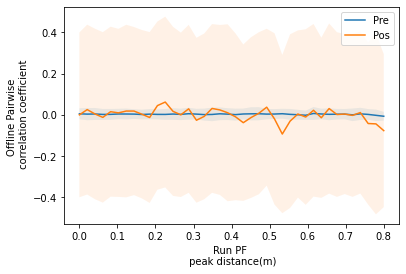

In [52]:
plot_corr(pre_dffs, pos_dffs, pl_peak)

#### all sessions

In [ ]:
plot_corr(pre_dffs, pos_dffs, pl_peak)

In [ ]:
# plot across map?

### offline population synchrony 3e

In [15]:
# get synchrony events from pre and post rest periods
# PSE population synchrony events
def get_syn(activity, velocity=None, sign='pre'):  # activity: [cell_id, activity across time] after smoothing
    population = np.mean(activity, axis=0)
    mean = np.mean(population)
    std = np.std(population)
    start = None
    end = None
    HSE_events = []
    if sign is 'run':
        for t in range(activity.shape[1]):
            if velocity[t] < 2:
                if population[t] > mean + 3.5 * std and (start is None):
                    start = t
                elif population[t] < mean + 1 * std and (start is not None):
                    end = t
                    if end - start >= 3: # should be 12
#                     print('pass one')
                        if np.where(np.mean(activity[:, start:end], axis=1)>0)[0].shape[0] >= 5:
                            HSE_events.append([start, end])
#                         print('one HSE events')
#                 print('reset')
                    start = None
    else:
        for t in range(activity.shape[1]):
            if population[t] > mean + 3.5 * std and (start is None):
                start = t
            elif population[t] < mean + 1 * std and (start is not None):
                end = t
                if end - start >= 3: # should be 12
#                     print('pass one')
                    if np.where(np.mean(activity[:, start:end], axis=1)>0)[0].shape[0] >= 5:
                        HSE_events.append([start, end])
#                         print('one HSE events')
#                 print('reset')
                start = None
    return HSE_events  # HSE of place cell

In [8]:
def plot_corr_syn(pre_dffs, pos_dffs, pl_peak): # dffs: [cell_id, activity]  pl_peak:[place field center(cm)]  one-to-one
    pl_num = len(pl_peak)
    pre_corr = np.corrcoef(pre_dffs)
    pos_corr = np.corrcoef(pos_dffs)
    pre_line = np.zeros(int(pl_num*(pl_num-1)/2))
    pos_line = np.zeros(pre_line.shape[0])
    pl_dis = np.zeros(pre_line.shape[0])
    for i in range(pl_num):
        for j in range(i):
            pl_dis[int((i-1)*i/2)+j] = abs(pl_peak[i]-pl_peak[j]) / 1000
            pre_line[int((i-1)*i/2)+j] = pre_corr[i, j]
            pos_line[int((i-1)*i/2)+j] = pos_corr[i, j]
    # put in 2cm position window 0.02m
    win = 0.02
    max_dis = np.max(pl_dis)
    min_dis = np.min(pl_dis)
    win_num = int((max_dis-min_dis)/win)+1
    pre_mean = np.zeros(win_num)
    pos_mean = np.zeros(win_num)
    nums = np.zeros(win_num)
    for k in range(len(pl_dis)):
        pre_mean[int(pl_dis[k]/win)] += pre_line[k]
        pos_mean[int(pl_dis[k]/win)] += pos_line[k]
        nums[int(pl_dis[k]/win)] += 1
    pre_mean /= nums
    pos_mean /= nums
    plt.scatter(np.log(pre_mean), np.log(pos_mean), marker='+')
    plt.plot(np.linspace(-10, -1, 100), np.linspace(-10, -1, 100), linestyle='--')
    plt.xlabel('Pre offline synchrony \n (mean corrected coefficient, log-scale)')
    plt.ylabel('Pos offline synchrony \n (mean corrected coefficient, log-scale)')
    plt.show()    

C:\Users\lily\anaconda3\envs\hippo_env\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log


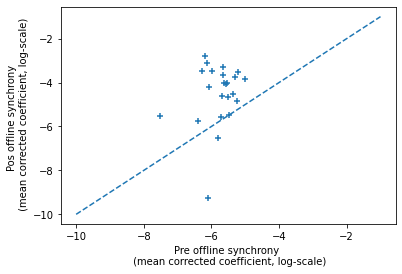

In [70]:
plot_corr_syn(pre_dffs, pos_dffs, pl_peak)

### find global reactivation events

In [16]:
# get PSEs
# 1. offline immobility, smooth with 125ms gaussian kernel:smooth
# 2. zscoring: zscore
# 3. get_syn
test = smooth(dff_traces)
test = zscore(test)
syn=get_syn(test, np.zeros(test.shape[1]))

In [90]:
# global: all cell activity

In [1]:
# heatmap
def syn_heatmap(HSE_events, activity):
    for event in HSE_events:
        if event[0] < 20:
            if event[1]+20>activity.shape[1]:
                around = activity[:, :]
                x_a = np.arange(activity.shape[1])
                x_s = np.arange(event[0],event[1],1)
            else:
                around = activity[:, :event[1]+20]
                x_a = np.arange(event[1]+20)
                x_s = np.arange(event[0],event[1],1)
        else:
            if event[1]+20>activity.shape[1]:
                around = activity[:, event[0]-20:]
                x_a = np.arange(event[0]-20, activity.shape[1], 1)
                x_s = np.arange(event[0],event[1],1)
            else:
                around = activity[:, event[0]-20:event[1]+20]
                x_a = np.arange(event[0]-20, event[1]+20, 1)
                x_s = np.arange(event[0],event[1],1)
        syn = activity[:, event[0]:event[1]]
   
        plt.subplot(211)
        plt.plot(x_a, np.mean(around, axis=0))
        plt.plot(x_s, np.mean(syn, axis=0))
        plt.subplot(212)
        plt.eventplot(event, lineoffsets=np.arange(event.shape[0]))
        plt.xlim(x_a[0], x_a[1])
        plt.xlabel('Frame')
        plt.ylabel('Cell no.')
        plt.show()

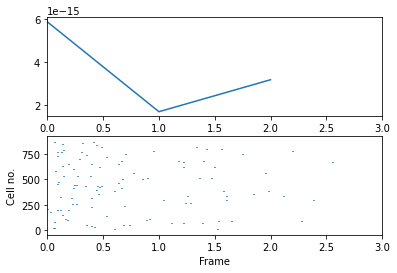

In [13]:
syn_heatmap(syn)

In [ ]:
# local: only place cell activity
# compare to chance rate
# get PSE from only place cells
# shuffle 2000 times: np.roll